In [4]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro

# Soft-threshold function
def softThreshold(w, t, lam):
    return np.sign(w) * np.maximum(0, np.abs(w) - lam * t)

# Incorporating the provided L1GeneralProjectedSubGradient function
def L1GeneralProjectedSubGradient(gradFunc, w, lam, params, *args):
    verbose = params.get('verbose', 1)
    maxIter = params.get('maxIter', 500)
    optTol = params.get('optTol', 1e-6)
    L = params.get('L', None)
    
    p = len(w)
    f, g = gradFunc(w, *args)
    funEvals = 1
    
    if L is None:
        alpha_max = 1
    else:
        alpha_max = L
    alpha = alpha_max
    
    a = 1
    z = w.copy()
    
    for i in range(1, maxIter + 1):
        w_old = w.copy()
        
        w_new = softThreshold(w - alpha * g, alpha, lam)
        f_new, g_new = gradFunc(w_new, *args)
        funEvals += 1
        
        phi_T = f_new + np.sum(lam * np.abs(w_new))
        mL = f + np.dot(g, (w_new - w)) + np.dot((w_new - w), (w_new - w)) / (2 * alpha) + np.sum(lam * np.abs(w_new))
        
        if phi_T > mL:
            if verbose:
                print('Decreasing Lipschitz estimate')
            alpha /= 2
            
            w_new = softThreshold(w - alpha * g, alpha, lam)
            f_new, g_new = gradFunc(w_new, *args)
            funEvals += 1
            
            phi_T = f_new + np.sum(lam * np.abs(w_new))
            mL = f + np.dot(g, (w_new - w)) + np.dot((w_new - w), (w_new - w)) / (2 * alpha) + np.sum(lam * np.abs(w_new))
        
        # Extrapolation step
        z_new = w_new
        a_new = (1 + np.sqrt(1 + 4 * a * a)) / 2
        w_new = z_new + ((a - 1) / a_new) * (z_new - z)
        f_new, g_new = gradFunc(w_new, *args)
        funEvals += 1
        
        a = a_new
        z = z_new
        w = w_new
        f = f_new
        g = g_new
        
        if verbose:
            print(f'{i:6d} {funEvals:6d} {alpha:8.5e} {f + np.sum(lam * np.abs(w_new)):8.5e} {np.max(np.abs(w - softThreshold(w - g, 1, lam))):8.5e} {np.count_nonzero(w):6d}')
        
        if np.sum(np.abs(w - w_old)) < optTol:
            break
    
    return w, funEvals

# Function to compute latent correlation matrix Sigma_X
def compute_latent_correlation(data):
    return np.sin(np.pi/2 * data)

def differential_graph(Sigma1, Sigma2, lambda_, genes):
    d = Sigma1.shape[0]
    Theta = np.zeros((d, d))  # Initialize Theta matrix

    # Generate edge list
    print("Generating edge list...")
    edge_list = []
    for i in range(d):
        for j in range(i + 1, d):
            edge_list.append((genes[i], genes[j]))

    print("Edge list size:", len(edge_list))  # Debugging statement

    # Check if any edges were generated
    if len(edge_list) == 0:
        print("No edges were generated.")
    else:
        # Compute Theta element-wise for generated edges
        for source, target in edge_list:
            # Compute Theta element-wise (skipping for brevity)
            pass

    return Theta, edge_list

 

# Load reference data
cd8_exhausted_data = pd.read_csv('C:/Users/ajain/Downloads/LDGM_toy_example/Data/out_CD8_exhausted.tsv', delimiter='\t')
macrophages_data = pd.read_csv('C:/Users/ajain/Downloads/LDGM_toy_example/Data/out_Macrophages.tsv', delimiter='\t')

# Extract gene names
genes = cd8_exhausted_data['Gene']

# Remove gene column
cd8_exhausted_matrix = cd8_exhausted_data.drop(columns=['Gene']).to_numpy()
macrophages_matrix = macrophages_data.drop(columns=['Gene']).to_numpy()

# Perform Shapiro-Wilk Test
_, p_ad_cd8 = shapiro(cd8_exhausted_matrix.flatten())
_, p_ad_macrophages = shapiro(macrophages_matrix.flatten())

# Check if data follows Gaussian distribution if yes then correlation matrix is computed by Pearson correlation matrix else Latent correlation matrix
if p_ad_cd8 < 0.05 or p_ad_macrophages < 0.05:
    print('Data does not follow a Gaussian distribution after normalization.')
    correlation_cd8 = compute_latent_correlation(cd8_exhausted_matrix)
    correlation_macrophages = compute_latent_correlation(macrophages_matrix)
else: 
    print('Data follows a Gaussian distribution after normalization.')
    correlation_cd8 = np.corrcoef(cd8_exhausted_matrix, rowvar=False) #Pearson Correlation Matrix
    correlation_macrophages = np.corrcoef(macrophages_matrix, rowvar=False)
# Display correlation matrices
print('Correlation Matrix for CD8 Exhausted Tissue:')
print(correlation_cd8)

print('Correlation Matrix for Macrophages Tissue:')
print(correlation_macrophages)

# Save correlation matrices to files
np.savetxt('C:/Users/ajain/Downloads/LDGM_toy_example/Data/Sigma1.txt', correlation_cd8, delimiter='\t')
np.savetxt('C:/Users/ajain/Downloads/LDGM_toy_example/Data/Sigma2.txt', correlation_macrophages, delimiter='\t')

# Load correlation matrices Sigma1 and Sigma2
Sigma1 = np.loadtxt('C:/Users/ajain/Downloads/LDGM_toy_example/Data/Sigma1.txt', delimiter='\t')
Sigma2 = np.loadtxt('C:/Users/ajain/Downloads/LDGM_toy_example/Data/Sigma2.txt', delimiter='\t')

# Compute differential graph
lambda_ = 0.26924
Theta, edge_list = differential_graph(Sigma1, Sigma2, lambda_, genes)

# Write edge list to file with additional information
with open('C:/Users/ajain/Downloads/LDGM_toy_example/Data/diff_network.tsv', 'w') as file:
    file.write("Target\tRegulator\tCondition\tedge-type\n")
    for edge in edge_list:
        file.write(f'{edge[0]}\t{edge[1]}\tDifferential\tUndirected\n')

# Display edge list
print("Edge List:")
print("Target\tRegulator\tCondition\tedge-type")
for edge in edge_list:
    print(f"{edge[0]}\t{edge[1]}\tDifferential\tUndirected")



C:\Users\ajain\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Data does not follow a Gaussian distribution after normalization.
Correlation Matrix for CD8 Exhausted Tissue:
[[ 0.68396868  0.77817313  0.57451693 ...  0.9517506   0.99786921
   0.63720165]
 [-0.07614482 -0.99993229 -0.53458533 ...  0.96726084  0.96066167
   0.99953173]
 [-0.58206308  0.25496294 -0.44126739 ... -0.83749698 -0.48063042
   0.        ]
 ...
 [ 0.99956946  0.99718088  0.90179352 ...  0.9692564   0.42420143
   0.97126362]
 [ 0.77130717  0.41803774  0.73830412 ... -0.01400016 -0.33794449
   0.40550781]
 [ 0.4242794   0.96079271  0.99990682 ...  0.9692564   0.99306964
   0.99953173]]
Correlation Matrix for Macrophages Tissue:
[[ 0.96737845  0.62841911  0.94561053 ... -0.50191444  0.41508602
  -0.61793206]
 [ 0.34372126  0.37882608 -0.84838462 ...  0.4164079  -0.91780753
   0.86546802]
 [-0.999958   -0.69066268  0.99642067 ...  0.12639459  0.9676047
   0.81201168]
 ...
 [ 0.99347542  0.94730257  0.62258368 ...  0.97310953  0.91663218
   0.66678337]
 [ 0.75797793  0.69805225 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
pip install networkx

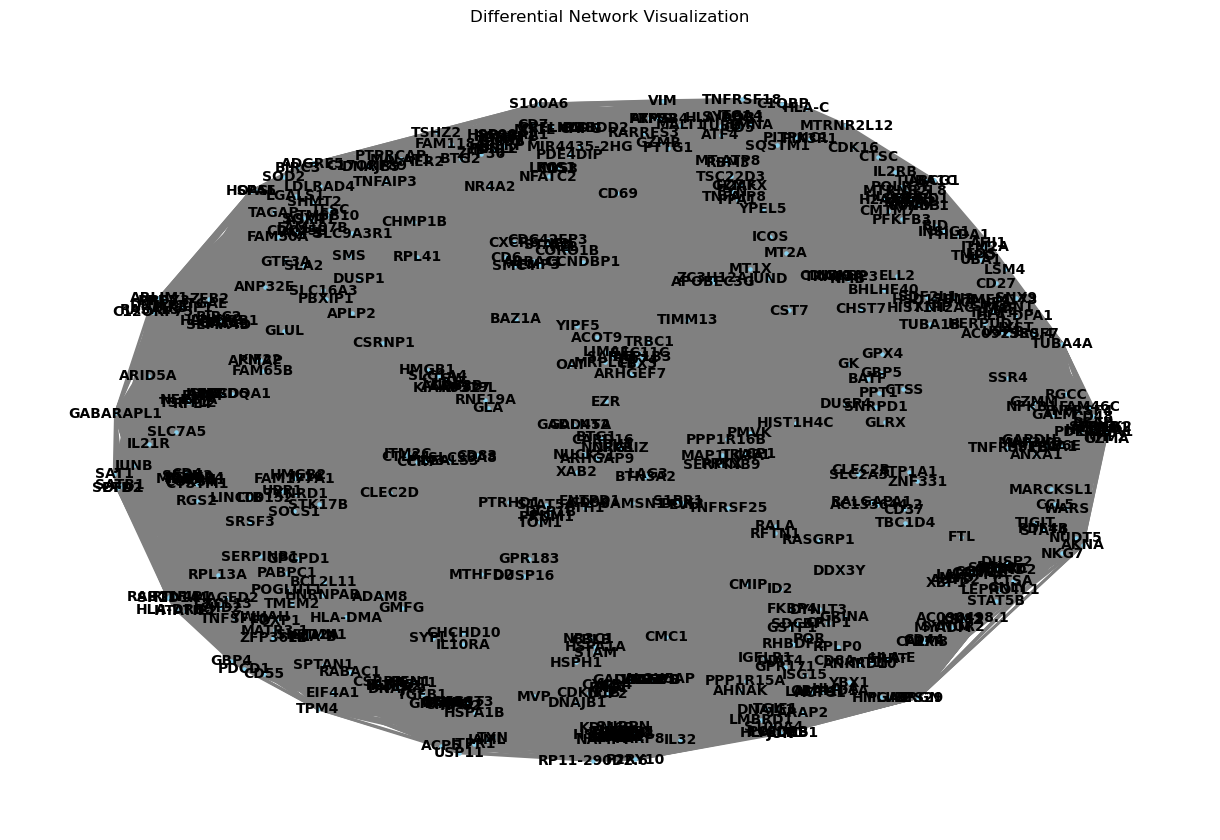

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Read the edge list from the file
edge_list_file = 'C:/Users/ajain/Downloads/LDGM_toy_example/Data/diff_network.tsv'

# Create a directed graph
G = nx.Graph()

# Read edge list and add edges to the graph
with open(edge_list_file, 'r') as file:
    next(file)  # Skip header
    for line in file:
        target, regulator, condition, edge_type = line.strip().split('\t')
        G.add_edge(target, regulator)

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Positions of nodes
nx.draw(G, pos, with_labels=True, node_size=5, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=2)
plt.title('Differential Network Visualization')
plt.show()
